# Persistent Effects of Federal Spending on Wages

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import re
import os
import os.path as osp

%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## FIPS Level Wage Statistics
The wage statistics from BLS are known to the county (actually FIPS code) level, and are aggregated over a host of industries. We're interested in two aggregation levels:
* agglvl_code = 70: FIPS code total wage statistics over all industries
* agglvl_code = 74: FIPS code total wage statistics by North American Industry Classification System (NAICS) sector, a coarse binning of industry sectors in the US

In [2]:
columns = ['area_fips', 
            'agglvl_code', 
            'industry_code',
            'total_annual_wages',
            'oty_annual_avg_wkly_wage_pct_chg',
            'lq_annual_avg_emplvl'
           ]
wages_by_sector = pd.DataFrame(columns = columns)
wages = pd.DataFrame(columns = columns)
for year in range(2005,2016):
    df = pd.read_csv('data/wage_stats/'+str(year)+'.annual.singlefile.csv',
                     usecols = columns,
                     dtype = {'area_fips': str,
                              'agglvl_code': int,
                              'industry_code': object,
                              'total_annual_wages': float,
                              'oty_annual_avg_wkly_wage_pct_chg': float,
                              'lq_annual_avg_emplvl': float
                             } 
                    )

    group = df.groupby('agglvl_code').get_group(74)
    group.loc[:,'year'] = str(year)[:4]
    wages_by_sector = wages_by_sector.append(group)
    group = df.groupby('agglvl_code').get_group(70)
    group.loc[:,'year'] = str(year)[:4]
    wages = wages.append(group)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## As a first pass, we can look for correlation between wages and federal spending over FIPS area pretty easily

In [3]:
median_wage_increase = wages.groupby('area_fips')['oty_annual_avg_wkly_wage_pct_chg'].median()
#median_wage_increase['area_fips'] = median_wage_increase.index
median_wage_increase = pd.DataFrame(median_wage_increase, columns = ['oty_annual_avg_wkly_wage_pct_chg'])
median_wage_increase['area_fips'] = median_wage_increase.index

In [4]:
m = Basemap(resolution='c', # c, l, i, h, f or None
            projection='merc',
            lat_0=54.5, lon_0=-4.36,
            llcrnrlon=-130.2, llcrnrlat= 23.9, urcrnrlon=-65.6, urcrnrlat=50.1)
m.readshapefile('data/shapefiles/UScounties/UScounties', 'areas', 
                linewidth = 0, 
                drawbounds = False,
                antialiased = False);

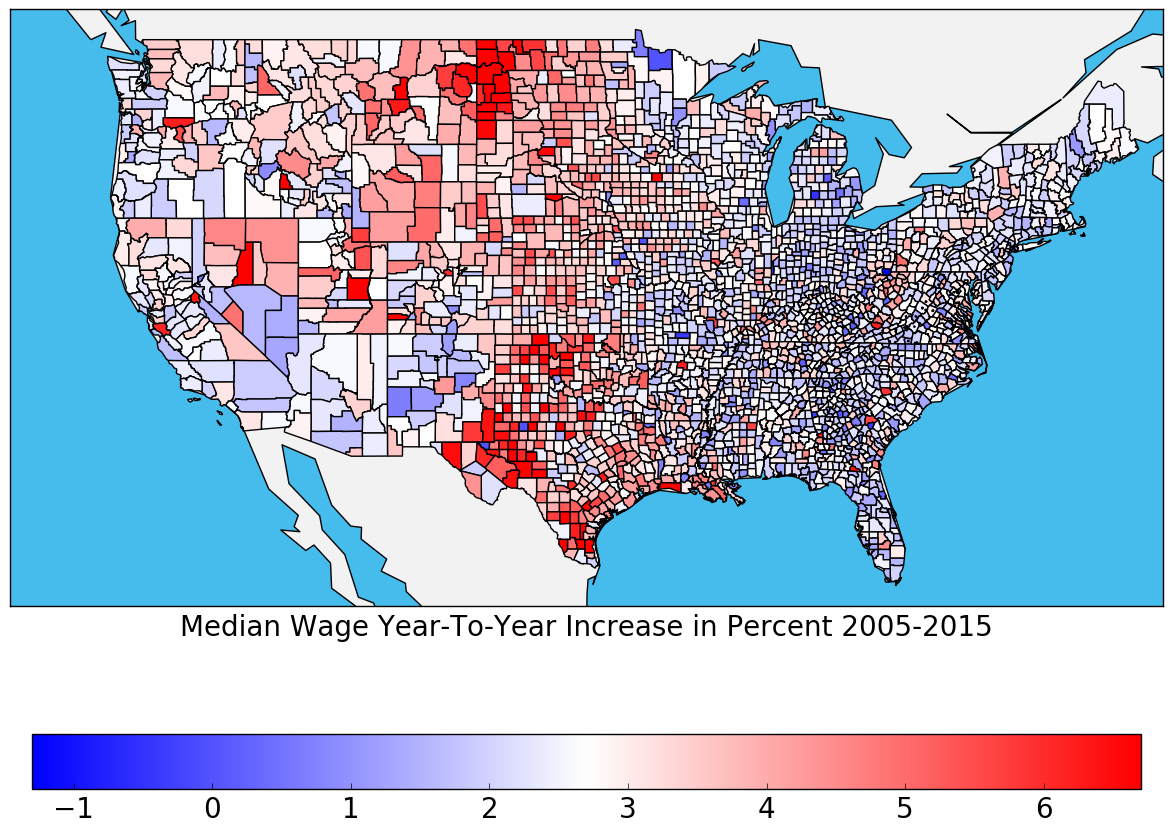

In [5]:


fig, ax = plt.subplots(figsize=(22,11))
poly_data = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.areas], 
                         'area':[area['FIPS'] for area in m.areas_info]})
poly_data = poly_data.merge(median_wage_increase, left_on = 'area', right_on = 'area_fips')

cmap = get_cmap('bwr')
median_val = poly_data['oty_annual_avg_wkly_wage_pct_chg'].median()
norm = Normalize(vmin = median_val-4, vmax = median_val + 4, clip = True)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
pc = PatchCollection(poly_data.shapes, zorder = 2, match_original = True)
pc.set_facecolor(cmap(norm(poly_data['oty_annual_avg_wkly_wage_pct_chg'].fillna(0).values)))
ax.add_collection(pc)
ax.set_xlabel(r'Median Wage Year-To-Year Increase in Percent 2005-2015', fontsize= 20)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(poly_data['oty_annual_avg_wkly_wage_pct_chg'])
cbar = plt.colorbar(mapper,shrink = 0.65, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=20) 


## To compare, let's grab the Federal Spending Data (this is around 100 GB, so it takes a while)

In [ ]:
def get_federal_spending(year):
    zip_countyfips = pd.read_csv('/Users/follin/Documents/projects/data_incubator/data_incubator/data/ZIP_COUNTY_122015/Sheet1-Table 1.csv',
                            memory_map = False,
                            usecols = ['ZIP', 'COUNTY'],
                            dtype = {'ZIP': str, 'COUNTY': str})
    data_dir = osp.join(os.getcwd(), 'data', str(year), 'datafeeds')
    files = [f for f in os.listdir(data_dir) if f[-3:]=='csv']
    cols = ['fed_funding', 'state', 'area_fips', 'ZIP']
    outframe = pd.DataFrame(columns = cols)
    for f in files:
        if f.find('Contracts') != -1:
            df = pd.read_csv(osp.join(data_dir, f),
                            usecols = ['dollarsobligated',
                                        'pop_state_code',
                                        'placeofperformancezipcode'
                                      ],
                            dtype = {'dollarsobligated': np.float64,
                                     'pop_state_code':  str,
                                     'placeofperformancezipcode': str
                                     },
                            )
            df['state'] = df.pop_state_code.apply(lambda x: re.sub('.*(?=[A-Z]{2}:)', '', 
                                                       re.sub('(?<=[A-Z]{2}:).*', '', 
                                                              re.sub(':','', x)))[:2])
            df['fed_funding'] = df.dollarsobligated
            df['ZIP'] = df['placeofperformancezipcode'].apply(lambda x: re.sub('[a-z]*|[A-z]*','',str(x))[:5])
            df['area_fips'] = df.merge(zip_countyfips, on = 'ZIP')['COUNTY']
        else:
            df = pd.read_csv(osp.join(data_dir, f),
                            usecols = ['fed_funding_amount',
                                        #'principal_place_state',
                                        'principal_place_zip',
                                        'principal_place_state_code',
                                        #'record_type'
                                        ],
                             dtype = {'fed_funding_amount': np.float64,
                                      'principal_place_zip': str,
                                      'principal_place_state_code': str
                                     }
                             )
            df['state'] = df.principal_place_state_code.apply(lambda x: re.sub('.*(?=[A-Z]{2}:)', '', 
                                                                        re.sub('(?<=[A-Z]{2}:).*', '', 
                                                                        re.sub(':','', str(x)
                                                                               )
                                                                                )
                                                                                 )[:2]
                                                             )
            df['fed_funding'] = df.fed_funding_amount
            df['ZIP'] = df['principal_place_zip'].apply(lambda x: re.sub('[a-z]*|[A-z]*','',str(x))[:5])
            #print set(df.ZIP)
            df['area_fips'] = df.merge(zip_countyfips, on = 'ZIP')['COUNTY']
            #print set(df.ZIP)


        df = df.groupby('area_fips', as_index = False).aggregate({'fed_funding':sum, 
                                                'ZIP': lambda x: list(x)[0],
                                               'state': lambda x: list(x)[0]
                                               })
        outframe = outframe.append(df[cols], ignore_index = True)
    outframe['year'] = str(year)
    return outframe

In [ ]:
Fed_Spending = pd.concat([get_federal_spending(year) for year in range(2005, 2016)])

In [ ]:
wages_and_spending = Fed_Spending.merge(wages, on = ['year', 'area_fips'])
wages_and_spending['log_spending_over_wage'] = log10(wages_and_spending['fed_funding']/wages_and_spending['total_annual_wages']).apply(lambda x: max(x, -10))

In [ ]:
aggregate_vals = wages_and_spending.groupby(['area_fips'], as_index = False).median()

In [ ]:
fig, ax = plt.subplots(figsize=(22,11))
poly_data = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.areas], 
                         'area':[area['FIPS'] for area in m.areas_info]})
poly_data = poly_data.merge(aggregate_vals, left_on = 'area', right_on = 'area_fips')

cmap = get_cmap('bwr')
median_val = poly_data['log_spending_over_wage'].median()
norm = Normalize(vmin = median_val-2, vmax = median_val + 2, clip = True)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
pc = PatchCollection(poly_data.shapes, zorder = 2, match_original = True)
pc.set_facecolor(cmap(norm(poly_data['log_spending_over_wage'].fillna(0).values)))
ax.add_collection(pc)
ax.set_xlabel(r'Median Federal Spending as Percent of Annual Wage 2005-2015', fontsize= 20)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(poly_data['log_spending_over_wage'])
cbar = plt.colorbar(mapper,shrink = 0.65, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_xticklabels(['%2.2f'%(10**(val+2)) for val in arange(-4, 0, 0.5)]);


In [ ]:
binedges = linspace(-4, 0, 8)
values = []
edges = []
for edge in binedges:
    #x_range = [edge, edge + 0.5]
    values += [[wage-1 for wage, ff in array(aggregate_vals[['oty_annual_avg_wkly_wage_pct_chg', 
                                                                'log_spending_over_wage']]
                                            ) 
                if ((ff) > edge) & ((ff) < edge + 0.5)]]
    edges += [edge]

In [ ]:
figure(figsize = (5, 3))
boxplot(values);
ylabel(r'% Median Increase (%)', fontsize = 10)
xlabel('Median Federal Spending/Total Annual Wage (%)', fontsize = 10)
title('Statistics by FIPS area')
ylim(-1, 5);
#plot([0,9],[0.21,0.21], c = 'g' ,lw = 3, label = 'inflation')
legend(frameon = False, loc = 4)
xticks(arange(1,9), [str(10**x)[:5] for x in edges])

# We can reduce variance by recognizing there are different 'populations' of FIPS regions defined by industry types

In [ ]:
county_classifications = pd.read_csv('/Users/follin/Downloads/53964_RuralAtlasCSVv13/County Classifications.csv',
                                    usecols = ['FIPStxt', 'Type_2015_Update'],
                                    #dtype= {'Type_2015_Update': int}
                                    )

county_classes = county_classifications[['FIPStxt', 'Type_2015_Update']]
county_classes.columns = ['area_fips', 'cluster']
county_classes['area_fips'] = county_classes['area_fips'].apply(lambda x: str(x).ljust(5,))
county_classes['area_fips']

In [ ]:
clustered_aggregate_vals = aggregate_vals.merge(county_classes.replace(np.nan, 0), on = 'area_fips')

In [ ]:
groups = clustered_aggregate_vals.groupby('cluster')
for name, (junk, group) in zip(['Unlabeled', 'Farm', 'Mining', 'Mfr.', 'Gvmt', 'Svcs.', 'Unspecialized'],groups):
    values = []
    binedges = [-10,-3,-2,-1,10]
    for left_edge, right_edge in zip(binedges[:-1], binedges[1:]):
        values += [[wage for wage, ff in array(group[['oty_annual_avg_wkly_wage_pct_chg', 
                                                      'log_spending_over_wage'
                                                     ]
                                                    ]
                                              )
                    if (ff > left_edge) & (ff < right_edge)
                   ]]
    figure(figsize = (5,3))
    boxplot(values);
    title(name)

In [ ]:
n_clusters = groups.size().size
fig, ax = plt.subplots(figsize=(22,11))
poly_data = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.areas], 
                         'area':[area['FIPS'] for area in m.areas_info]})
poly_data = poly_data.merge(clustered_aggregate_vals, left_on = 'area', right_on = 'area_fips')

cmap = get_cmap('Set2', n_clusters)
median_val = poly_data['cluster'].median()
norm = Normalize(vmin = -1, vmax = n_clusters-1, clip = True)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
pc = PatchCollection(poly_data.shapes, zorder = 2, match_original = True)
pc.set_facecolor(cmap(norm(poly_data['cluster'].fillna(0).values)))
ax.add_collection(pc)
ax.set_xlabel(r'Median Federal Spending as Percent of Annual Wage 2005-2015', fontsize= 20)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(poly_data['cluster'])
cbar = plt.colorbar(mapper, shrink = 0.65, orientation = 'horizontal', ticks = (arange(-1, n_clusters-1)+0.45))
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_xticklabels(['Unlabeled', 'Farm', 'Mining', 'Mfr.', 'Gvmt', 'Svcs.', 'Unspecialized']);

In [ ]:
n_clusters.size

## Scratch below

In [ ]:
prefix = 'IC'
wbs_dummies = pd.get_dummies(wages_by_sector, columns = ['industry_code'], prefix = prefix)
IC_cols = [col for col in wbs_dummies.columns if col.startswith(prefix)]
for col in IC_cols:
    wbs_dummies[col] = wbs_dummies['lq_annual_avg_emplvl'] * wbs_dummies[col]



In [ ]:
IC_cols += ['area_fips']
wbs_gb_region = wbs_dummies[IC_cols].groupby('area_fips').max()

#wbs_gb_region.columns = arange(21)

In [ ]:
features = log(wbs_gb_region + 0.01)
colnames = features.columns
indexer = features.index

In [ ]:
features
from sklearn.decomposition import FactorAnalysis
from numpy.linalg import svd

In [ ]:
u,s,v = svd(features)
u.shape


In [ ]:
scatter(arange(len(s)),s)

In [ ]:
selected_features = dot(features, v)

In [ ]:
n_clusters = 4
fips_to_cluster = pd.DataFrame(pd.DataFrame(selected_features, columns = arange(21), index = indexer)[arange(n_clusters)].idxmax(axis = 1))

In [ ]:
fips_to_cluster['area_fips'] = fips_to_cluster.index
fips_to_cluster.columns = ['cluster', 'area_fips']

In [ ]:
fips_to_cluster

In [ ]:
aggregate_vals = aggregate_vals.merge(fips_to_cluster, on = 'area_fips')

In [ ]:
aggregate_vals

In [ ]:
groups = aggregate_vals.groupby('cluster')
groups.count()

In [ ]:
for name, group in groups:
    values = []
    binedges = [-10,-3,-2,-1,10]
    for left_edge, right_edge in zip(binedges[:-1], binedges[1:]):
        values += [[wage for wage, ff in array(group[['oty_annual_avg_wkly_wage_pct_chg', 
                                                      'log_spending_over_wage'
                                                     ]
                                                    ]
                                              )
                    if (ff > left_edge) & (ff < right_edge)
                   ]]
    figure(figsize = (5,3))
    boxplot(values);

    #    hist(group['log_spending_over_wage'], bins = linspace(-5,0,10));
##     edges = []
#     #print group['log_spending_over_wage'].describe()
#     binedges = group.loc[:, 'log_spending_over_wage'].quantile(linspace(0,1,5))
#     print binedges
#     #binedges = linspace(-5,0,5)
#     #print len(binedges) - 1
#     for left_edge, right_edge in zip(binedges[:-1], binedges[1:]):

        
#         values += [[wage for wage, ff in array(group[['oty_annual_avg_wkly_wage_pct_chg', 
#                                                                 'log_spending_over_wage']]
#                                             ) 
#                 if ((ff) > left_edge) & ((ff) < right_edge)]]
#         edges += [edge]
#     print values
#     #print len(values)
#     figure(figsize = (5, 3))
#     boxplot(values);
#     ylabel(r'% Median Increase (%)', fontsize = 10)
#     xlabel('Median Federal Spending/Total Annual Wage (%)', fontsize = 10)
#     title('Statistics by FIPS area: Group %3d'%name)
#     #ylim(-1, 5);
#     #plot([0,9],[0.21,0.21], c = 'g' ,lw = 3, label = 'inflation')
#     legend(frameon = False, loc = 4)
#     xticks(arange(1,5), ['%1.2f to %1.2f'%(x,y) for x,y in zip(binedges[:-1], binedges[1:])])
        

In [ ]:
fig, ax = plt.subplots(figsize=(22,11))
poly_data = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.areas], 
                         'area':[area['FIPS'] for area in m.areas_info]})
poly_data = poly_data.merge(aggregate_vals, left_on = 'area', right_on = 'area_fips')

cmap = get_cmap('Set2', n_clusters)
median_val = poly_data['cluster'].median()
norm = Normalize(vmin = 0, vmax = n_clusters, clip = False)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
pc = PatchCollection(poly_data.shapes, zorder = 2, match_original = True)
pc.set_facecolor(cmap(norm(poly_data['cluster'].fillna(0).values)))
ax.add_collection(pc)
ax.set_xlabel(r'Median Federal Spending as Percent of Annual Wage 2005-2015', fontsize= 20)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(poly_data['cluster'])
cbar = plt.colorbar(mapper, shrink = 0.65, orientation = 'horizontal', ticks = (arange(n_clusters)+0.45))
cbar.ax.tick_params(labelsize=20) 
cbar.ax.set_xticklabels(['%2d'%x for x in arange(n_clusters)]);

In [ ]:
poly_data

In [ ]:
transformed = pca.fit_transform(features)
labels = classifier.fit_predict(transformed)
pca.inverse_transform?

In [ ]:
norm = Normalize(vmin = 0, vmax = 9)
cmap = get_cmap('Set3')
scatter(transformed[:,0], transformed[:,1], c = cmap(norm(labels)),s = 6, lw = 0)

In [ ]:
cmap = get_cmap('Set3')

In [ ]:
wbs_gb_region.sum().merge(fips_class_labels, right_on = 'area_fips')

In [ ]:
df = wbs_gb_region.sum()
df['area_fips'] = df.index

In [ ]:
class_means = df.merge(fips_class_labels, on = 'area_fips').groupby('class_label').mean()
class_std = df.merge(fips_class_labels, on = 'area_fips').groupby('class_label').std()
for index in arange(10):
    errorbar(arange(len(class_means.columns)),
             [class_means.loc[index, col] for col in class_means.columns],
            #yerr = [class_std.loc[index, col] for col in class_std.columns],
            fmt = 'o')


In [ ]:
data = wbs_gb_region.max()

In [ ]:
max_cols =[]
for loc in data.index:
    max_cols += [i for i,col in enumerate(data.columns) if data.loc[loc, col] == max(data.loc[loc,:])]
data['']

In [ ]:
hist(max_cols, bins = arange(len(data.columns)));

In [ ]:
col = [col for col in county_classifications.columns if col[:4] == 'Type'] + ['FIPStxt']


In [ ]:
county_classes.replace(np.nan, -1).groupby('cluster').count()

In [ ]:
aggregate_vals = aggregate_vals.merge(county_classes.replace(np.nan, -1, on = 'area_fips')

In [ ]:
aggregate_vals